## Import Libraries

In [5]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA

import griddb_python as griddb

## Loading Data

In [6]:
data = pd.read_csv('data.csv')

In [7]:
data.head(3)

,name,club,age,position,position_cat,market_value,page_views,fpl_value,fpl_sel,fpl_points,region,nationality,new_foreign,age_cat,club_id,big_club,new_signing
0,Alexis Sanchez,Arsenal,28,LW,1,65.0,4329,12.0,17.10%,264,3,Chile,0,4,1,1,0
1,Mesut Ozil,Arsenal,28,AM,1,50.0,4395,9.5,5.60%,167,2,Germany,0,4,1,1,0
2,Petr Cech,Arsenal,35,GK,4,7.0,1529,5.5,5.90%,134,2,Czech Republic,0,6,1,1,0


In [8]:
data.shape

(460, 17)

In [9]:
data.columns

Index(['name', 'club', 'age', 'position', 'position_cat', 'market_value',
       'page_views', 'fpl_value', 'fpl_sel', 'fpl_points', 'region',
       'nationality', 'new_foreign', 'age_cat', 'club_id', 'big_club',
       'new_signing'],
      dtype='object')

In [10]:
data = data.dropna()

In [11]:
data.isnull().sum().sum()

0

In [12]:
data.dtypes

name             object
club             object
age               int64
position         object
position_cat      int64
market_value    float64
page_views        int64
fpl_value       float64
fpl_sel          object
fpl_points        int64
region            int64
nationality      object
new_foreign       int64
age_cat           int64
club_id           int64
big_club          int64
new_signing       int64
dtype: object

In [13]:
data['name'] = data['name'].apply(lambda x: x.encode('utf-8').decode('utf-8'))
data[['age', 'position_cat', 'market_value', 'page_views', 'fpl_value', 'fpl_points', 'region', 'new_foreign', 'age_cat', 'club_id', 'big_club', 'new_signing']] = data[['age', 'position_cat', 'market_value', 'page_views', 'fpl_value', 'fpl_points', 'region', 'new_foreign', 'age_cat', 'club_id', 'big_club', 'new_signing']].astype(float)

## Setting Up a Container in Griddb to Store the Data

In [ ]:
factory = griddb.StoreFactory.get_instance()

# Provide the necessary arguments
gridstore = factory.get_store(
    host = '239.0.0.1',
    port = 31999,
    cluster_name = 'defaultCluster',
    username = 'admin',
    password = 'admin'
)

# Define the container info
conInfo = griddb.ContainerInfo(
    "football_players",
    [
        ["name", griddb.Type.STRING],
        ["club", griddb.Type.STRING],
        ["age", griddb.Type.DOUBLE],
        ["position", griddb.Type.STRING],
        ["position_cat", griddb.Type.DOUBLE],
        ["market_value", griddb.Type.DOUBLE],
        ["page_views", griddb.Type.DOUBLE],
        ["fpl_value", griddb.Type.DOUBLE],
        ["fpl_sel", griddb.Type.STRING],
        ["fpl_points", griddb.Type.DOUBLE],
        ["region", griddb.Type.DOUBLE],
        ["nationality", griddb.Type.STRING],
        ["new_foreign", griddb.Type.DOUBLE],
        ["age_cat", griddb.Type.DOUBLE],
        ["club_id", griddb.Type.DOUBLE],
        ["big_club", griddb.Type.DOUBLE],
        ["new_signing", griddb.Type.DOUBLE]
    ],
    griddb.ContainerType.COLLECTION, True
)

# Drop container if it exists
gridstore.drop_container(conInfo.name)

# Create a container
container = gridstore.put_container(conInfo)

# Load the data

# Put rows
for i in range(len(data)):
  row = data.iloc[i].tolist()
  try:
    container.put(row)
  except Exception as e:
    print(f"Error on row {i}: {row}")
    print(e)

cont = gridstore.get_container("football_players")

if cont is None:
  print("Does not exist")

print("connection successful")

# Define the exact columns you need
columns = ["*"]

select_statement = "SELECT " + ", ".join(columns) + " FROM football_players"

# Execute the query
query = container.query(select_statement)
rs = query.fetch(False)

data = rs.fetch_rows()

print(data.head())

## Recommendation System

<Axes: >

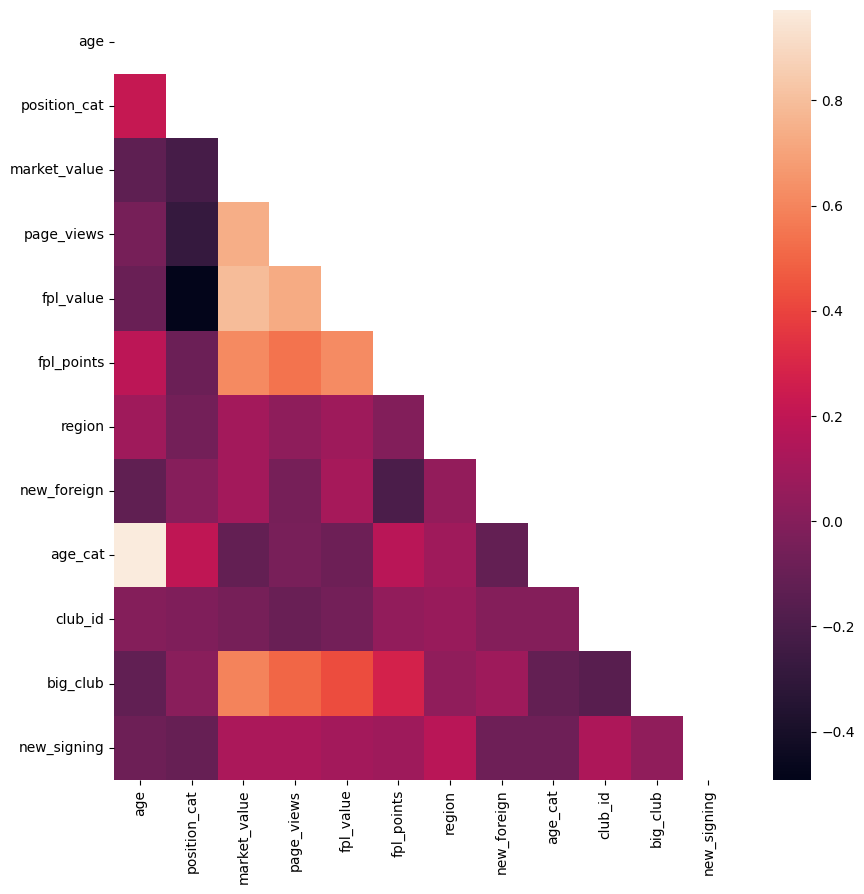

In [14]:
sample = data.select_dtypes(include='number')
corr = sample.corr()
mask = np.zeros_like(corr, dtype = np.bool_)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(10,10))
sns.heatmap(corr, mask=mask)

In [15]:
scaled = StandardScaler()
X = scaled.fit_transform(sample)
recommendations = NearestNeighbors(n_neighbors = 5, algorithm='kd_tree')
recommendations.fit(X)
player_index = recommendations.kneighbors(X)[1]

In [16]:
def find_index(x):
    return data[data['name']==x].index.tolist()[0]

def recommendation_system(player):
    print("Here are four players who are similar to {}: ".format(player))
    index =  find_index(player)
    for i in player_index[index][1:]:
        print("Player Name: {}\nPlayer Market Value: {}\nPlayer Age: {}\nPlayer Current Club: {}\n".format(data.iloc[i]['name'],
                                                                                        data.iloc[i]['market_value'],
                                                                                        data.iloc[i]['age'],
                                                                                        data.iloc[i]['club']))

In [17]:
recommendation_system('Petr Cech')

Here are four players who are similar to Petr Cech: 
Player Name: Willy Caballero
Player Market Value: 1.5
Player Age: 35.0
Player Current Club: Chelsea

Player Name: Nacho Monreal
Player Market Value: 13.0
Player Age: 31.0
Player Current Club: Arsenal

Player Name: Laurent Koscielny
Player Market Value: 22.0
Player Age: 31.0
Player Current Club: Arsenal

Player Name: Artur Boruc
Player Market Value: 1.0
Player Age: 37.0
Player Current Club: Bournemouth

